# Defining the Model Grid

The model grid for a simulation needs to be configured at both compile time and run time. There are two main options for configuring grids -- regular grids and more complex grids using the exch2 package.

## Rectangular Grids

Considee a simple ocean model domain that has dimensions of 40 cells in the x-direction (`Nx`), 20 cells in the y-direction (`Ny`), and 10 cells in the z-direction (`Nr`). In python ordering, this grid has dimensions (10, 40, 80):

In [1]:
import numpy as np
Nx = 40
Ny = 20
Nr = 10
grid = np.zeros((Nr, Ny, Nx))
print('Grid shape:',np.shape(grid))

Grid shape: (10, 20, 40)


We could visualize this grid in the horizontal direction as follows:

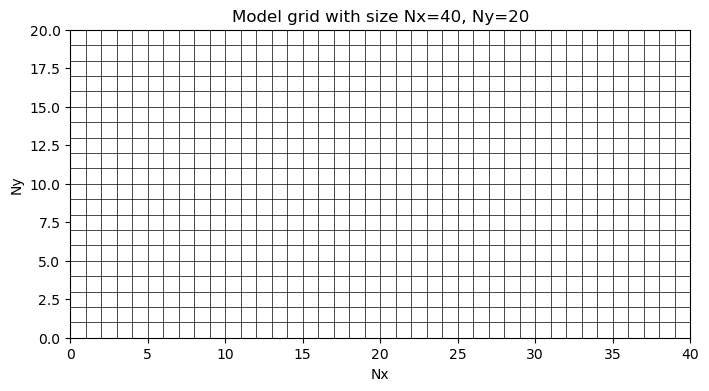

In [2]:
import matplotlib.pyplot as plt

# define the cell edges
x_cell_edges = np.arange(Nx+1)
y_cell_edges = np.arange(Ny+1)

# plot the grid
fig = plt.figure(figsize = (8,4))
for i in range(Nx+1):
    plt.plot(x_cell_edges[i]*np.ones((Ny+1,)), y_cell_edges, 'k-', linewidth=0.5)
for j in range(Ny+1):
    plt.plot(x_cell_edges, y_cell_edges[j]*np.ones((Nx+1,)), 'k-', linewidth=0.5)
    
# format and show
plt.gca().set_xlim([0,Nx])
plt.gca().set_ylim([0,Ny])
plt.xlabel('Nx')
plt.ylabel('Ny')
plt.title('Model grid with size Nx='+str(Nx)+', Ny='+str(Ny))
plt.show()

### Compile time files for regular grids
The key compile time file for generating the model grid is the `SIZE.h` file. A custom `SIZE.h` file must be created for each model configuration otherwise the model will not compile.

In the SIZE.h file, Nr is specified directly. However, `Nx` and `Ny` are a function of how the grid is partitioned for parallelization. If the model is only going to be run on one CPU, then set `sNx = Nx` and `sNy = Ny` in the SIZE.h file.

When partitioning the grid to be run in parallel, the domain is divided into tiles of size (`sNy`, `sNy`) where `sNy` is the number of rows in the processing tile and `sNx` is the number of columns. Each tile will be run on a separate CPU with `Px` total processors in the x-direction and Py total processeors in the y-direction for a total number of processors `Px*Py`.

For example, we could define our processing tiles to have size `sNx=20` and `sNy=10`, so that  `Px=2` and `Py=2`, visualized as follows: 

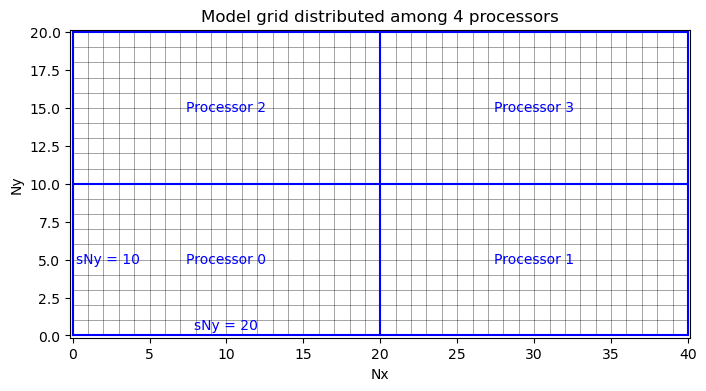

In [3]:
fig = plt.figure(figsize = (8,4))

# plot the main grid
for i in range(Nx+1):
    plt.plot(x_cell_edges[i]*np.ones((Ny+1,)), y_cell_edges, 'k-', linewidth=0.5, alpha = 0.5)
for j in range(Ny+1):
    plt.plot(x_cell_edges, y_cell_edges[j]*np.ones((Nx+1,)), 'k-', linewidth=0.5, alpha = 0.5)

# plot each processor
sNx = 20
sNy = 10
plt.plot(x_cell_edges[0]*np.ones((Ny+1,)), y_cell_edges, 'b-')
plt.plot(x_cell_edges[sNx]*np.ones((Ny+1,)), y_cell_edges, 'b-')
plt.plot(x_cell_edges[-1]*np.ones((Ny+1,)), y_cell_edges, 'b-')
plt.plot(x_cell_edges, y_cell_edges[0]*np.ones((Nx+1,)),'b-')
plt.plot(x_cell_edges, y_cell_edges[sNy]*np.ones((Nx+1,)),'b-')
plt.plot(x_cell_edges, y_cell_edges[-1]*np.ones((Nx+1,)),'b-')

# annotate
plt.text(sNx/2,sNy/2,'Processor 0', color='blue', ha='center',va='center')
plt.text(sNx*1.5,sNy/2,'Processor 1', color='blue', ha='center',va='center')
plt.text(sNx/2,sNy*1.5,'Processor 2', color='blue', ha='center',va='center')
plt.text(sNx*1.5,sNy*1.5,'Processor 3', color='blue', ha='center',va='center')
plt.text(0.2,sNy/2,'sNy = '+str(sNy), color='blue', ha='left',va='center')
plt.text(sNx/2,0.2,'sNy = '+str(sNx), color='blue', ha='center',va='bottom')
    
# format and show
plt.gca().set_xlim([-0.15,Nx+0.15])
plt.gca().set_ylim([-0.15,Ny+0.15])
plt.xlabel('Nx')
plt.ylabel('Ny')
plt.title('Model grid distributed among 4 processors')
plt.show()

There is also an option for multi-threading, which is similar to the case for multiprocessing, However, this is not commonly used on computing clusters, so a full description is omitted here.

### Runtime files for regular grids
There are several options for generating a regular model grid. Most options are specified in the `data` file in the `PARM04` namelist.

#### Specifying grid in the `data` file
When using a simple evenly-spaced grid, the grid can be specified directly in the `PARM04` namelist. For example, consider the regular grid above with a 20 km spacing in both the x- and y- directions. This would be specified in the `PARM04` namelist as:
```
usingCartesianGrid=.TRUE.,
delX=40*20.E3,
delY=20*20.E3,
xgOrigin= 0.E3,
ygOrigin= 0.E3,
```

#### Specifying grids in a tile file
There is also an option to store your grids in a "tile file" to have them read at run time. When no grid information is provided in the `data` file and the option `usingCurvilinearGrid` is specified in `PARM04`, the model will search for the tile file in the run directory at run time. For model run on a sinple CPU, the file should be named `tile001.mitgrid`. When running on multple CPUs, the tile files are specific to each processing tile and the names are incremented, e,g. `tile001.mitgrid`, `tile002.mitgrid`, `tile003.mitgrid`, and `tile004.mitgrid`.

```{note}
When using multiple processors, a separate tile file must be provided for each processing tile.
```

A tile file is composed of 16 different fields organized in a stack of size (16, Ny, Nx) where the 16 fields are defined as follows:

| Variable Name | Description |
| ------------- | ----------- |
| XC | X-coordinate of cell center |
| YC | Y-coordinate of cell center |
| DXF | (Update Description) |
| DYF | (Update Description) |
| RAC | Cell area measured at the center of the cell |
| XG | X-coordinate of cell lower-left corner |
| YG | Y-coordinate of cell lower-left corner |
| DXV | Cell width measured between velocity location on lower boundary of the cell |
| DYU | Cell height measured between velocity location on left boundary of the cell |
| RAZ | (Update Description) |
| DXC | Cell width measured between cell center points |
| DYC | Cell height measured between cell center points |
| RAW | (Update Description) |
| RAS | (Update Description) |
| DXG | Cell width measured between lower-left corner points |
| DYG | Cell height measured between lower-left corner points |



If you would like to create a tile file manually, it's highly recommended that you check out the [simplegid](https://github.com/nasa/simplegrid) package designed to generate these these fields when provided with `XC` and `YC`.

We can visualize these fields as follows:

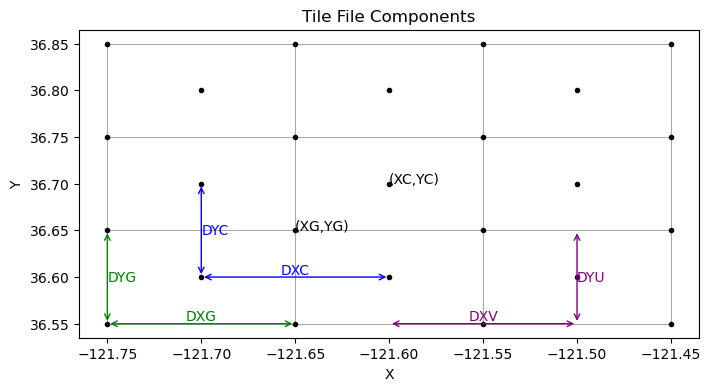

In [4]:
fig = plt.figure(figsize = (8,4))

# define the grid 
xg = np.arange(-121.75,-121.36,0.1)
yg = np.arange(36.55,36.94,0.1)
XG, YG = np.meshgrid(xg, yg)
xc = np.arange(-121.7,-121.49,0.1)
yc = np.arange(36.6,36.9,0.1)
XC, YC = np.meshgrid(xc, yc)

# plot the grid
for i in range(len(xg)):
    plt.plot(xg[i]*np.ones((len(yg),)), yg, 'k-', linewidth=0.5, alpha = 0.5)
for j in range(len(yg)):
    plt.plot(xg, yg[j]*np.ones((len(xg),)), 'k-', linewidth=0.5, alpha = 0.5)
plt.plot(XC,YC,'k.')
plt.plot(XG,YG,'k.')

# annotate
plt.text(xc[1],yc[1],'(XC,YC)')
plt.text(xg[1],yg[1],'(XG,YG)')

plt.annotate('', xy=(xc[0],yc[0]), xytext=(xc[1],yc[0]), arrowprops=dict(arrowstyle='<->', color='blue'))
plt.text(xg[1],yc[0],'DXC',color='blue',ha='center',va='bottom')
plt.annotate('', xy=(xc[0],yc[0]), xytext=(xc[0],yc[1]), arrowprops=dict(arrowstyle='<->', color='blue'))
plt.text(xc[0],yg[1],'DYC',color='blue',ha='left',va='center')

plt.annotate('', xy=(xg[0],yg[0]), xytext=(xg[1],yg[0]), arrowprops=dict(arrowstyle='<->', color='green'))
plt.text(xc[0],yg[0],'DXG',color='green',ha='center',va='bottom')
plt.annotate('', xy=(xg[0],yg[0]), xytext=(xg[0],yg[1]), arrowprops=dict(arrowstyle='<->', color='green'))
plt.text(xg[0],yc[0],'DYG',color='green',ha='left',va='center')

plt.annotate('', xy=(xc[1],yg[0]), xytext=(xc[2],yg[0]), arrowprops=dict(arrowstyle='<->', color='purple'))
plt.text(xg[2],yg[0],'DXV',color='purple',ha='center',va='bottom')
plt.annotate('', xy=(xc[2],yg[0]), xytext=(xc[2],yg[1]), arrowprops=dict(arrowstyle='<->', color='purple'))
plt.text(xc[2],yc[0],'DYU',color='purple',ha='left',va='center')


# format and show
# plt.gca().set_xlim([-0.15,Nx+0.15])
# plt.gca().set_ylim([-0.15,Ny+0.15])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Tile File Components')
plt.show()

## Grids with exch2

### Compile time files for exch2
The exch2 package offers a more flexible way to construct model grids, allowing for the partitioning of a model grid into model "faces". This option is commonly used for large global models, such as the Lat-Lon-Cap grid used in the ECCO State Estimates. One major upshot of the exch2 package is that it allows for the use of "blank tiles" - tiles that are in the model grid but should not be included in the procssing. This is most common when there are no wet cells in the particular tile.  

When using exch2, the tile sizes are specified in `sNx` and `sNy` just like the rectangular grid case. However, in the exch2 geometry, all of the tiles are stacked in the x-direction - `Px` is set as the number of non-blank tiles and Py is set to 1. Nr is still the number of vertical levels in the model.

Note that when using the exch2 package, exch2 must be added to the list of packages in the packages.conf file.